# **Preparing Unstructured Text Data for fine-tuning of Retrieval Models**

***
## In this walkthrough we'll take a look at injecting domain context into sentence transformer models using Generative Pseudo Labeling (GPL).

### Required Libraries

There are a few Python libraries we must <span style="color:green;"> pip install </span> for this notebook to run, those are:

In [2]:
!pip install -qU langchain tiktoken matplotlib seaborn tqdm datasets sentence-transformers faiss-gpu

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 2023.58.190319 requires jupyter-server~=1.16, but you have jupyter-server 2.5.0 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.10.1 which is incompatible.
ydata-profiling 4.1.2 requires matplotlib<3.7,>=3.2, but you have matplotlib 3.7.2 which is incompatible.
ydata-profiling 4.1.2 requires scipy<1.10,>=1.4.1, but you have scipy 1.10.1 which is incompatible.
ydata-profiling 4.1.2 requires tqdm<4.65,>=4.48.2, but you have tqdm 4.65.0 which is incompatible.


### Required Package Imports
There are a few Python libraries we must <span style="color:green;"> import </span> import for this notebook to run, those are:

In [3]:
from sentence_transformers import SentenceTransformer, util, InputExample, losses
from torch.utils.data import DataLoader 
from sentence_transformers import CrossEncoder 
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM 
import tqdm 
import random
from datasets import load_dataset 
import pandas as pd
from pathlib import Path
import json
import os
import csv
import numpy as np
import faiss
import torch

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

### We start by loading our private dataset which is hosted on hugging face

In [4]:
# Insert the identifier for your dataset and user auth token here
dataset = load_dataset(
    path="Insert/Your/HuggingFace/Dataset",
    use_auth_token="Insert/Your/HuggingFace/AuthToken"
)


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/Avinaash___csv/Avinaash--rbinotifs-ce8ad51135b18a83/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

**Lets view a single sample from the dataset loaded. In this walkthrough we are using an unstructured dataset created scraping all of the notifications published by the Reserve Bank of India until Mar 2023**

In [5]:
len(dataset['train']['doc_text'])

12461

In [6]:
dataset['train']['doc_text'][0]

' Notifications (63 kb)Mid-term Review of Monetary and Credit Policy for 1998-99 Statement by Dr.Bimal Jalan,Governor, Reserve Bank of India on Mid-Term Review of Monetary and Credit Policy for 1998-99 Introduction It will be recalled that in the last Monetary and Credit Policy Statement on April 29, 1998, it was indicated that a review of credit and monetary developments in the first half of the year will be undertaken in October of each year. It was also indicated that the October review would generally be in the nature of a mid-term review of monetary developments during the year, and will not necessarily involve changes in credit policy measures. 2. This statement consists of three parts: (i) Mid-term review of Macro-Economic and Monetary Developments in 1998-99, (ii) Stance of Monetary Policy for the second half of 1998-99, and (iii) Monetary and Financial Sector Reforms. No changes in short-term measures such as the Bank Rate, CRR, Repo rate are being announced at this point of t

In [7]:
docs = dataset['train']['doc_text']

# What are the steps in Generative Psuedo Labelling?
* We collate unstructure text data from the domain. In the walkthrough, the dataset under consideration is the list of all of the notifications put out by the Reserve Bank of India (RBI)
* **Step 1:** The unstructured text data is then chunked into a collection of paragraphs to handle the limitations around token (or sub-words) in the models that we would be using in the below steps  
* **Step 2:** For the collection of paragraphs from the desired domain, we utilize an existing pre-trained T5 encoder-decoder to generate suitable queries. 
* **Step 3:** These generated queries are used to mine negative passages. 
* **Step 4:** Finally, we use an existing cross-encoder to score each (query, passage)-pair and train a dense retrieval model on these generated, pseudo-labeled queries using MarginMSE-Loss.

***

# Step 1. Breaking our document down into smaller chunks
* In this walkthrough we would be making use of msmarco-t5-base-v1 for the query generation step.

* In the "msmarco-t5-base-v1" model, tokens typically represent subword units generated by the SentencePiece tokenizer. For example, a word like "unhappiness" could be tokenized into subwords like "un", "##hap", and "##piness", where the "##" prefix denotes subwords that are part of a larger word.

* It's important to note that the token limit of the "msmarco-t5-base-v1" model is 512 tokens. 

* We would be using tiktoken (by HuggingFace) to first look at the distribution of the tokens across the dataset and then to chunk the docs into a corpus of paragraphs

In [12]:
import tiktoken

tokenizer = tiktoken.get_encoding('cl100k_base')

# create the length function
def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)

In [13]:
token_counts = [tiktoken_len(doc) for doc in docs]

In [14]:
print(f"""Min: {min(token_counts)}
Avg: {int(sum(token_counts) / len(token_counts))}
Max: {max(token_counts)}""")

Min: 4
Avg: 1876
Max: 63372


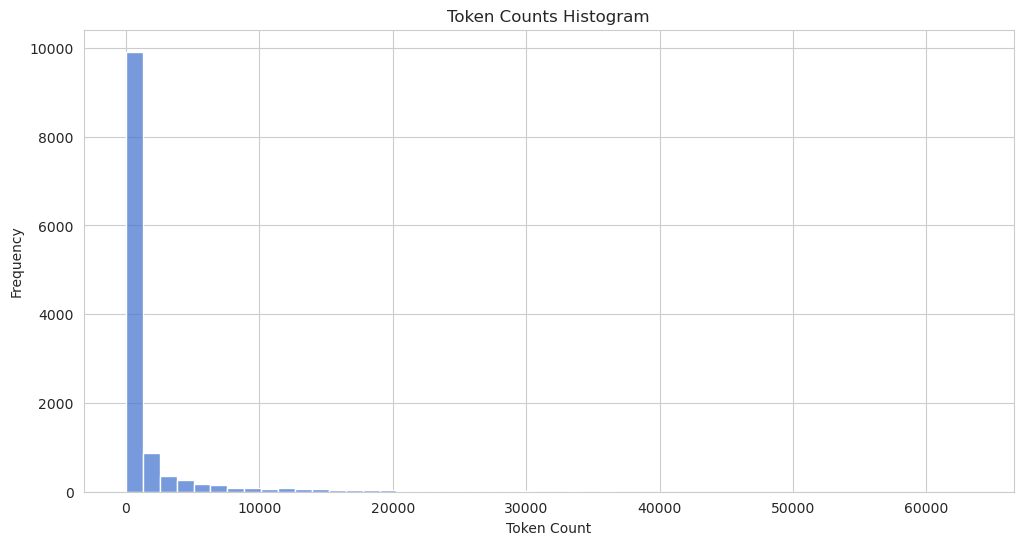

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# set style and color palette for the plot
sns.set_style("whitegrid")
sns.set_palette("muted")

# create histogram
plt.figure(figsize=(12, 6))
sns.histplot(token_counts, kde=False, bins=50)

# customize the plot info
plt.title("Token Counts Histogram")
plt.xlabel("Token Count")
plt.ylabel("Frequency")

plt.show()

**Now that we have visualized the distribution of the data, we proceed to chunking it using langchain's text splitter**

In [16]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=350,
    chunk_overlap=20,  # number of tokens overlap between chunks
    length_function=tiktoken_len,
    separators=['\n\n', '\n', ' ', '']
)

In [17]:
chunks = text_splitter.split_text(docs[0])
len(chunks)

32

In [18]:
chunks[:2]

['Notifications (63 kb)Mid-term Review of Monetary and Credit Policy for 1998-99 Statement by Dr.Bimal Jalan,Governor, Reserve Bank of India on Mid-Term Review of Monetary and Credit Policy for 1998-99 Introduction It will be recalled that in the last Monetary and Credit Policy Statement on April 29, 1998, it was indicated that a review of credit and monetary developments in the first half of the year will be undertaken in October of each year. It was also indicated that the October review would generally be in the nature of a mid-term review of monetary developments during the year, and will not necessarily involve changes in credit policy measures. 2. This statement consists of three parts: (i) Mid-term review of Macro-Economic and Monetary Developments in 1998-99, (ii) Stance of Monetary Policy for the second half of 1998-99, and (iii) Monetary and Financial Sector Reforms. No changes in short-term measures such as the Bank Rate, CRR, Repo rate are being announced at this point of t

In [19]:
tiktoken_len(chunks[0]), tiktoken_len(chunks[30])

(350, 349)

In [20]:
from tqdm.auto import tqdm

corpus = []

for doc in tqdm(docs):
    chunks = text_splitter.split_text(doc)
    for chunk in enumerate(chunks):
        corpus.append(chunk)

  0%|          | 0/12461 [00:00<?, ?it/s]

### The dataset is brokendown into chunks, with each chunk being with 350 tokens

In [21]:
len(corpus)

76758

In [29]:
df = pd.DataFrame(corpus, columns=['Index', 'Text'])

In [24]:
with open('corpus.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(corpus)

# Step 2. We utilize an existing pre-trained T5 encoder-decoder to generate suitable queries for the collection of chunks from the desired domain.
* In this walkthrough we would be making use of *msmarco-t5-base-v1* for the query generation step.

* doc2query/msmarco-t5-base-v1 (docT5query) | Link: https://huggingface.co/doc2query/msmarco-t5-base-v1


In [30]:
corpus = df['Text'].tolist()

In [31]:
t5_name = 'doc2query/msmarco-t5-base-v1'

t5_tokenizer = AutoTokenizer.from_pretrained(t5_name)
t5_model = AutoModelForSeq2SeqLM.from_pretrained(t5_name).cuda()

In [32]:
query_doc_pairs = []
batch_size = 32
queries_per_doc = 3
max_seq_length = 512

for start_idx in tqdm(range(0,len(corpus),batch_size)) :
    corpus_batch = corpus[start_idx:start_idx+batch_size]
    enc_inp = t5_tokenizer(corpus_batch,
                            max_length=max_seq_length, 
                            truncation=True, 
                            padding=True, 
                            return_tensors='pt')
    outputs = t5_model.generate(input_ids=enc_inp['input_ids'].cuda(), 
                                attention_mask=enc_inp['attention_mask'].cuda(), 
                                max_length=64, 
                                do_sample=True, 
                                top_p=0.95, 
                                num_return_sequences=queries_per_doc,)
    
    decoded_output = t5_tokenizer.batch_decode(outputs, skip_special_tokens=True)
    
    for idx, query in enumerate(decoded_output):
        corpus_id = int(idx/queries_per_doc)
        query_doc_pairs.append([query, corpus_batch[corpus_id]])
        
print("Generated queries:", len(query_doc_pairs))

  0%|          | 0/2399 [00:00<?, ?it/s]

Generated queries: 230274


In [33]:
query_doc_pairs[:5]

[['what date was a mid term review of monetary policy',
  'Notifications (63 kb)Mid-term Review of Monetary and Credit Policy for 1998-99 Statement by Dr.Bimal Jalan,Governor, Reserve Bank of India on Mid-Term Review of Monetary and Credit Policy for 1998-99 Introduction It will be recalled that in the last Monetary and Credit Policy Statement on April 29, 1998, it was indicated that a review of credit and monetary developments in the first half of the year will be undertaken in October of each year. It was also indicated that the October review would generally be in the nature of a mid-term review of monetary developments during the year, and will not necessarily involve changes in credit policy measures. 2. This statement consists of three parts: (i) Mid-term review of Macro-Economic and Monetary Developments in 1998-99, (ii) Stance of Monetary Policy for the second half of 1998-99, and (iii) Monetary and Financial Sector Reforms. No changes in short-term measures such as the Bank Ra

In [35]:
with open('queries.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Query', 'Document'])
    for pair in query_doc_pairs:
        writer.writerow(pair)


### Note: Steps 1 & 2 do not require a GPU to run. Separate the above code and run it in a Kaggle notebook. Then create a dataset using the output of Step 2.   

# Step 3. Use pre-trained T5 encoder-decoder to mine negative passages. 

* doc2query/msmarco-t5-base-v1 (docT5query) | Link: https://huggingface.co/doc2query/msmarco-t5-base-v1


In [4]:
max_seq_length = 512
model_name = "msmarco-distilbert-base-tas-b"

org_model = SentenceTransformer(model_name)
org_model.max_seq_length = max_seq_length

#### This cell reads the contents of the dataset obtained as the output of Step 2, i.e. one that contains the query-document pairs. The pairs are stored in the query_doc_pairs list. The first row, which typically contains the header, is skipped.

In [5]:
query_doc_pairs = []

with open('/kaggle/input/rbiqueries/20230608_rbi_queries.csv', mode='r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row if it exists
    
    for row in reader:
        query_doc_pairs.append(row)

In [6]:
query_doc_pairs[:2]

[['what date was a mid term review of monetary policy',
  'Notifications (63 kb)Mid-term Review of Monetary and Credit Policy for 1998-99 Statement by Dr.Bimal Jalan,Governor, Reserve Bank of India on Mid-Term Review of Monetary and Credit Policy for 1998-99 Introduction It will be recalled that in the last Monetary and Credit Policy Statement on April 29, 1998, it was indicated that a review of credit and monetary developments in the first half of the year will be undertaken in October of each year. It was also indicated that the October review would generally be in the nature of a mid-term review of monetary developments during the year, and will not necessarily involve changes in credit policy measures. 2. This statement consists of three parts: (i) Mid-term review of Macro-Economic and Monetary Developments in 1998-99, (ii) Stance of Monetary Policy for the second half of 1998-99, and (iii) Monetary and Financial Sector Reforms. No changes in short-term measures such as the Bank Ra

#### Here, a CSV file (20230608_rbi_corpus.csv) containing a corpus of documents is read into a pandas DataFrame. The DataFrame is then converted to a list called corpus, which contains the document texts.

In [12]:
column_names = ['index', 'corp']  

df_corpus = pd.read_csv('/kaggle/input/rbicorpus/20230608_rbi_corpus.csv', names=column_names)

In [13]:
corpus = df_corpus['corp'].tolist()

In [14]:
corpus[:2]

['Notifications (63 kb)Mid-term Review of Monetary and Credit Policy for 1998-99 Statement by Dr.Bimal Jalan,Governor, Reserve Bank of India on Mid-Term Review of Monetary and Credit Policy for 1998-99 Introduction It will be recalled that in the last Monetary and Credit Policy Statement on April 29, 1998, it was indicated that a review of credit and monetary developments in the first half of the year will be undertaken in October of each year. It was also indicated that the October review would generally be in the nature of a mid-term review of monetary developments during the year, and will not necessarily involve changes in credit policy measures. 2. This statement consists of three parts: (i) Mid-term review of Macro-Economic and Monetary Developments in 1998-99, (ii) Stance of Monetary Policy for the second half of 1998-99, and (iii) Monetary and Financial Sector Reforms. No changes in short-term measures such as the Bank Rate, CRR, Repo rate are being announced at this point of t

#### In this cell, the documents in the corpus are encoded into dense vector representations using the initialized org_model. The encode() method takes the corpus list as input and returns the encoded representations as PyTorch tensors. The shape of the resulting tensor is printed to check the dimensions.

In [15]:
corpus_emb = org_model.encode(corpus, convert_to_tensor=True, show_progress_bar=True)
corpus_emb.shape

Batches:   0%|          | 0/2399 [00:00<?, ?it/s]

torch.Size([76758, 768])

#### Set up the FAISS index for efficient nearest neighbor search. 
* First, an index object is created with the same dimensionality as the document vectors. 
* Then, the tensor corpus_emb is moved to the GPU if available. 
* Next, the tensor is converted to a numpy array, and the index is initialized. 
* Finally, the document vectors are added to the index

In [16]:
# Set up the FAISS index with the same dimensionality as the vectors
index = faiss.IndexFlatIP(corpus_emb.shape[1])

In [17]:
# Move tensor to GPU
corpus_emb = corpus_emb.cuda()

# Convert tensor to numpy array
corpus_emb_np = corpus_emb.detach().cpu().numpy()

# Initialize index
d = corpus_emb_np.shape[1]
index = faiss.IndexFlatIP(d)

# Add the vectors to the index
index.add(corpus_emb_np)


#### Generate triplets of (query, positive document, negative document) for training the model. 
It iterates over the query_doc_pairs list in batches of size batch_size. For each batch, the queries and positive documents are extracted. The queries are encoded into vectors using org_model. Nearest neighbor search is performed to find the negative documents for each query. The resulting triplets are stored in the triplets list.

In [18]:
batch_size = 100
triplets = []

for i in range(0, len(query_doc_pairs), batch_size):
    i_end = min(i+batch_size, len(query_doc_pairs))
    queries = [pair[0] for pair in query_doc_pairs[i:i_end]]
    pos_docs = [pair[1] for pair in query_doc_pairs[i:i_end]]
    query_embs = org_model.encode(queries, convert_to_tensor=True, show_progress_bar=False)
    # Move tensor to GPU
    query_embs = query_embs.cuda()
    # Convert tensor to numpy array
    query_embs_np = query_embs.detach().cpu().numpy()
    # Find the nearest neighbors to each query
    distances, ids = index.search(query_embs_np, k=11)
    # Skip the first result, which is the query itself
    for query, pos_doc, query_ids, query_distances in zip(queries, pos_docs, ids, distances):
        for hit_id, hit_dist in zip(query_ids[1:], query_distances[1:]):
            neg_doc = corpus[int(hit_id)]
            if neg_doc != pos_doc:
                triplets.append([query, pos_doc, neg_doc])
                break

#### Write the generated triplets to a CSV file named triplets.csv. This is the output of Step 3.

In [19]:
import csv

with open('triplets.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Query', 'Positive Document', 'Negative Document'])
    for triplet in triplets:
        writer.writerow(triplet)

### Note: Steps 3 is a GPU intensive step to run. Separate Step 3 and run it in a Kaggle notebook. Then create a dataset using the triplets.csv file, which is generated as the output of Step 3.   

# Step 4. Use an existing cross-encoder to score each (query, passage)-pair and train a dense retrieval model on these generated, pseudo-labeled queries using MarginMSE-Loss.

* Cross-encoder model used: cross-encoder/ms-marco-MiniLM-L-6-v2 | Link: https://huggingface.co/cross-encoder/ms-marco-MiniLM-L-6-v2

* Dense retrival model used: msmarco-distilbert-base-tas-b | Link: https://huggingface.co/sentence-transformers/msmarco-distilbert-base-tas-b


In [20]:
import csv
if os.path.exists('/kaggle/input/tripmedium/triplets.csv'):
    triplets = []
    with open('/kaggle/input/tripmedium/triplets.csv', mode='r') as file:
        reader = csv.reader(file)
        # Skip the header row
        next(reader)
        # Iterate over remaining rows
        for row in reader:
            query, pos_doc, neg_doc = row
            triplets.append([query, pos_doc, neg_doc])
else:
    print("File triplets.csv does not exist.")

File triplets.csv does not exist.


In [21]:
triplets[:2]

[['what date was a mid term review of monetary policy',
  'Notifications (63 kb)Mid-term Review of Monetary and Credit Policy for 1998-99 Statement by Dr.Bimal Jalan,Governor, Reserve Bank of India on Mid-Term Review of Monetary and Credit Policy for 1998-99 Introduction It will be recalled that in the last Monetary and Credit Policy Statement on April 29, 1998, it was indicated that a review of credit and monetary developments in the first half of the year will be undertaken in October of each year. It was also indicated that the October review would generally be in the nature of a mid-term review of monetary developments during the year, and will not necessarily involve changes in credit policy measures. 2. This statement consists of three parts: (i) Mid-term review of Macro-Economic and Monetary Developments in 1998-99, (ii) Stance of Monetary Policy for the second half of 1998-99, and (iii) Monetary and Financial Sector Reforms. No changes in short-term measures such as the Bank Ra

#### CrossEncoder model (cross-encoder/ms-marco-MiniLM-L-6-v2) is instantiated. 
* Then, for each triplet in triplets, the CrossEncoder model predicts the relevance scores for the (query, positive) and (query, negative) pairs. 
* The difference between the two scores is computed and stored as the label. 
* The resulting InputExample objects, consisting of the texts and labels, are appended to the train_examples list. 
* The label, texts, and an example InputExample object are printed for verification.

In [ ]:
cross_model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")
train_examples = []
for query, pos, neg in triplets:
    #Compute CrossEncoder score for (query, pos) and (query, neg) pairs
    scores = cross_model.predict([[query, pos], [query, neg]], show_progress_bar=False)
    
    #Compute the difference (margin) of (query, pos) and (query, neg)
    score_margin = scores[0]-scores[1]
    train_examples.append(InputExample(texts=[query, pos, neg], label=score_margin))

In [ ]:
train_examples[0].label

In [ ]:
train_examples[0].texts

In [ ]:
train_examples[0]

#### Train the dense retrival model (msmarco-distilbert-base-tas-b)
* This cell loads the training examples from the file train_examples.csv and creates a train_dataloader to iterate over the examples in batches. 
* Dense retrival model (msmarco-distilbert-base-tas-b) is instantiated with the specified model name and maximum sequence length. The training loss is defined as a margin-based mean squared loss. 
* Finally, the model is trained for a specified number of epochs, with warmup steps to adjust the learning rate.

In [ ]:
max_seq_length = 256
model_name = "msmarco-distilbert-base-tas-b"

# org_model = SentenceTransformer(model_name)
# org_model.max_seq_length = max_seq_length

In [ ]:
train_examples = []
with open('/kaggle/input/rbitrainexamples/train_examples.csv', mode='r') as file:
    reader = csv.reader(file)
    next(reader) # skip header row
    for row in reader:
        text1, text2, text3, label = row
        train_examples.append(InputExample(texts=[text1, text2, text3], label=float(label)))

In [ ]:
train_examples[:4]

In [ ]:
model = SentenceTransformer(model_name)
model.max_seq_length = max_seq_length
train_dataloader = DataLoader(train_examples, batch_size=16,drop_last=True, shuffle=True)
train_loss = losses.MarginMSELoss(model)

In [ ]:
#Tuning the model
model.fit(train_objectives=[(train_dataloader,train_loss)],
         epochs=3,
         warmup_steps=int(len(train_dataloader)*0.1))

In [ ]:
import torch

In [ ]:
model.save('msmarco-distilbert-base-tas-b-rbi')